In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict, Counter
from gensim.models import Word2Vec

## Loading and preprocessing data:

In [26]:
df_resto = pd.read_csv('../data/restaurants.csv')
df_users = pd.read_csv('../data/users.csv')

In [7]:
model_ncf = tf.keras.models.load_model('../models/ncf_model.h5')
model_word2vec = Word2Vec.load('../models/word2vec.model')

In [27]:
def preprocess_df_resto(df_resto):
    df_resto['category'] = df_resto['category'].apply(lambda x: x.lower().replace(' ', '').replace('[', '').replace(']', '').replace("'", '').split(','))
    return df_resto

def preprocess_df_users(df_users):
    df_users['list_of_resto'] = df_users['list_of_resto'].apply(eval)
    df_users = df_users[df_users['latitude'].notnull()]
    return df_users

In [28]:
# preprocess dataframes
df_resto = preprocess_df_resto(df_resto)
df_users = preprocess_df_users(df_users)

## Defining the different recommenders:

In [10]:
def popularity_score(df_resto, m=50):  # m is the number of reviews starting from which the restaurant mean rating becomes more reliable that the global mean rating
    avg_rating = df_resto['avg_rating'].mean()  # mean rating of all restaurants
    # calculate the popularity score for each restaurant
    result = (df_resto['num_of_reviews']/(df_resto['num_of_reviews']+m))*df_resto['avg_rating']\
        + (m/(df_resto['num_of_reviews']+m))*avg_rating
    return result

In [12]:
def get_category_score(df_resto, sim_map):  # sim_map is a dictionary that contains the similarity between each category and the user's preferences
    try:
        return df_resto['category'].apply(lambda x: np.mean([sim_map[c] for c in x]))  # return the mean similarity between the restaurant's categories and the user's preferences
    except:
        return np.zeros(len(df_resto))

In [31]:
def knowledge_score(df_resto, sim_map, user_price, user_lat_norm, user_lng_norm, weights):
    results = df_resto[['gmap_id']].copy()
    results['price_sim'] = 1-df_resto['price'].apply(lambda x: np.abs(x-user_price))/3   # similarity between restaurants prices and the user's preferred price, normalized to [0,1]
    results['category_sim'] = get_category_score(df_resto, sim_map)  # similarity between restaurants categories and the user's preferred categories, normalized to [0,1]
    results['location_sim'] = 1-np.sqrt((df_resto['norm_lat']-user_lat_norm)**2 + (df_resto['norm_lng']-user_lng_norm)**2)  # similarity between restaurants locations and the user's selected location, normalized to [0,1]
    results['score'] = results['price_sim']*weights['price'] + results['category_sim']*weights['category'] + results['location_sim']*weights['location']  # weighted sum of the three similarities
    results['score'] *= 5  # normalize the score to [0,5]
    return results['score']

In [32]:
def content_based_score(df_resto, sim_map, user_price_hist, user_lat_hist, user_lng_hist, weights):
    results = df_resto[['gmap_id']].copy()
    results['price_sim'] = 1-df_resto['price'].apply(lambda x: np.abs(x-user_price_hist))/3  # similarity between restaurants prices and the user's history price, normalized to [0,1]
    results['category_sim'] = get_category_score(df_resto, sim_map)  # similarity between restaurants categories and the user's history categories, normalized to [0,1]
    results['location_sim'] = 1-np.sqrt((df_resto['norm_lat']-user_lat_hist)**2 + (df_resto['norm_lng']-user_lng_hist)**2)  # similarity between restaurants locations and the user's history locations, normalized to [0,1]
    results['score'] = results['price_sim']*weights['price'] + results['category_sim']*weights['category'] + results['location_sim']*weights['location']  # weighted sum of the three similarities
    results['score'] *= 5
    return results['score']

In [33]:
def collab_score(df_resto, user_code, model):
    nb_resto = df_resto.shape[0]
    result = df_resto[['gmap_id']].copy()
    result['score'] = model.predict([np.array([user_code]*nb_resto), df_resto['resto_code']]).reshape(-1)  # predict the rating that the user would give to each restaurant
    return result['score']

In [17]:
def popularity_rec_weight(n):  # n is the number of interactions of the user with the system
    return 0.95 - 0.9/(1+np.exp(-0.5*n))  # weight attributed to the popularity score given the number of interactions

def knowledge_rec_weight(n):
    return 0.85 - 0.7/(1+np.exp(-0.5*n))  # weight attributed to the knowledge score given the number of interactions

def content_rec_weight(n):
    return 1.6/(1+np.exp(-0.5*n)) - 0.8/(1+np.exp(-0.05*n)) - 0.4  # weight attributed to the content score given the number of interactions

def collab_rec_weight(n):
    return 0.8/(1+np.exp(-0.05*n)) - 0.4  # weight attributed to the collaborative score given the number of interactions

In [59]:
def recommend_to_existing_user(df_resto, df_user, user_id, model_ncf, model_wv, categories, r=0.05, k=10):  # r is the radius of the circle around the user's location in which the restaurants are selected, and k the number of restaurants to recommend
    assert user_id in df_user['user_id'].values, 'The user_id is not in the dataframe'  # check if the user_id is in the dataframe

    # get the user's data
    user = df_user[df_user['user_id'] == user_id].iloc[0]  # get the user's row
    user_price = user['avg_price']
    user_lat = user['latitude'] 
    user_lng = user['longitude']
    user_code = user['user_code']
    history = user['list_of_resto']
    
    # normalize the user's location
    min_lat, max_lat = df_resto['latitude'].min(), df_resto['latitude'].max()
    min_lng, max_lng = df_resto['longitude'].min(), df_resto['longitude'].max()
    user_lat_norm = (user_lat - min_lat)/(max_lat - min_lat)  # normalize the user's latitude
    user_lng_norm = (user_lng - min_lng)/(max_lng - min_lng)  # normalize the user's longitude
    
    # get the user's favorite categories and their weight from his history
    fav_cats = Counter() 
    df_history = df_resto[df_resto['gmap_id'].isin(history)]
    df_history['category'].apply(lambda x: fav_cats.update(Counter(x)))
    if 'restaurant' in fav_cats:
        del fav_cats['restaurant']  # remove the generic category 'restaurant'
    fav_cats = {k:v for k, v in fav_cats.items() if k in sorted(fav_cats, key=fav_cats.get, reverse=True)[:5]}  # keep only the 5 most frequent categories
    fav_cats = {k: v/sum(fav_cats.values()) for k, v in fav_cats.items()}  # normalize the weights to sum to 1
    print(f'User info :\nid: {user_id}\npreferred price: {round(user_price, 2)}\nlocation: ({user_lat}, {user_lng})\nhistory: {history}\npreferred categories: {list(fav_cats.keys())}')

    # compute the similarity between the user's favorite categories and the restaurants' categories
    sim_map = defaultdict(lambda: 0)
    sim_map.update({c: np.sum([model_wv.wv.similarity(c, k)*fav_cats[k] for k in fav_cats]) for c in categories if c in model_wv.wv.key_to_index})

    # get the restaurants in the circle around the user's location
    min_nb_resto_around = 100
    df_resto['distance'] = np.sqrt((df_resto['latitude']-user_lat)**2 + (df_resto['longitude']-user_lng)**2)
    if  df_resto[df_resto['distance'] <= r].shape[0] >= min_nb_resto_around:
        df_resto = df_resto[df_resto['distance'] <= r].copy()
    else:
        df_resto = df_resto.sort_values(by='distance', ascending=True).head(min_nb_resto_around).copy()

    # compute the weight of each recommendation method given the number of interactions of the user with the system
    n = len(history)
    weights = {'popu_rec': popularity_rec_weight(n), 'knowledge_rec': knowledge_rec_weight(n), 'content_rec': content_rec_weight(n), 'collab_rec': collab_rec_weight(n)}
    
    # compute the score of each restaurant given the recommendation methods
    df_resto['popularity_score'] = popularity_score(df_resto) if weights['popu_rec'] > 0 else 0
    df_resto['knowledge_score'] = knowledge_score(df_resto, sim_map, user_price, user_lat_norm, user_lng_norm, {'price': 0.2, 'location': 0.3, 'category': 0.5}) if weights['knowledge_rec'] > 0 else 0
    df_resto['content_score'] = content_based_score(df_resto, sim_map, user_price, user_lat_norm, user_lng_norm, {'price': 0.2, 'location': 0.3, 'category': 0.5}) if weights['content_rec'] > 0 else 0
    df_resto['collab_score'] = collab_score(df_resto, user_code, model_ncf) if weights['collab_rec'] > 0 else 0

    # compute the final score of each restaurant with a weighted sum of the scores
    df_resto['score'] = df_resto['popularity_score']*weights['popu_rec'] + df_resto['knowledge_score']*weights['knowledge_rec'] + df_resto['content_score']*weights['content_rec'] + df_resto['collab_score']*weights['collab_rec']
    return df_resto.sort_values(by='score', ascending=False).head(k)  # return the k best restaurants

In [60]:
def recommend_to_new_user(df_resto, user_lat, user_lng, user_price, user_categories, model_wv, categories, r=0.05, k=10):  # r is the radius of the circle around the user's location in which the restaurants are selected, and k the number of restaurants to recommend 
    # normalize the user's location
    min_lat, max_lat = df_resto['latitude'].min(), df_resto['latitude'].max()
    min_lng, max_lng = df_resto['longitude'].min(), df_resto['longitude'].max()
    user_lat_norm = (user_lat - min_lat)/(max_lat - min_lat)  # normalize the user's latitude
    user_lng_norm = (user_lng - min_lng)/(max_lng - min_lng)  # normalize the user's longitude
    
    if 'restaurant' in categories:
        categories.remove('restaurant')  # remove the generic category 'restaurant'
    fav_cats = {k: 1/len(user_categories) for k in user_categories}  # normalize the weights to sum to 1
    print(f'User info :\npreferred price: {round(user_price, 2)}\nlocation: ({user_lat}, {user_lng})\npreferred categories: {user_categories}')

    # compute the similarity between the user's favorite categories and the restaurants' categories
    sim_map = defaultdict(lambda: 0)
    sim_map.update({c: np.sum([model_wv.wv.similarity(c, k)*fav_cats[k] for k in fav_cats]) for c in categories if c in model_wv.wv.key_to_index})

    # get the restaurants in the circle around the user's location
    min_nb_resto_around = 100
    df_resto['distance'] = np.sqrt((df_resto['latitude']-user_lat)**2 + (df_resto['longitude']-user_lng)**2)
    if  df_resto[df_resto['distance'] <= r].shape[0] >= min_nb_resto_around:
        df_resto = df_resto[df_resto['distance'] <= r].copy()
    else:
        df_resto = df_resto.sort_values(by='distance', ascending=True).head(min_nb_resto_around).copy()

    weights = {'popu_rec': 0.2, 'knowledge_rec': 0.8}
    
    # compute the score of each restaurant given the recommendation methods
    df_resto['popularity_score'] = popularity_score(df_resto) if weights['popu_rec'] > 0 else 0
    df_resto['knowledge_score'] = knowledge_score(df_resto, sim_map, user_price, user_lat_norm, user_lng_norm, {'price': 0.2, 'location': 0.3, 'category': 0.5}) if weights['knowledge_rec'] > 0 else 0

    # compute the final score of each restaurant with a weighted sum of the scores
    df_resto['score'] = df_resto['popularity_score']*weights['popu_rec'] + df_resto['knowledge_score']*weights['knowledge_rec']
    return df_resto.sort_values(by='score', ascending=False).head(k)  # return the k best restaurants

In [35]:
# get the set of all the categories
all_categories = set()
df_resto['category'].apply(lambda x: all_categories.update(set(x)))
print(f'There are {len(all_categories)} different categories, such as {list(all_categories)[:5]}')

There are 347 different categories, such as ['northeasternindianrestaurant', 'salvadoranrestaurant', 'hungarianrestaurant', 'cheesesteakrestaurant', 'koreanribrestaurant']


## Using the recommender:

### On an existing user:

In [41]:
# choose a user from the dataset
user = df_users.iloc[599]
user_id = user['user_id']

In [42]:
# using the recommender:
recommendations = recommend_to_existing_user(df_resto, df_users, user_id, model_ncf, model_word2vec, all_categories)
recommendations

User info :
id: 114848446501799714678
preferred price: 1.6203007518796992
location: (37.8027509537037, -122.25107430185186)
history: ['0x808fcdfa6f4687ef:0x7fb26e5dee794dc4', '0x808fcdfa6f4687ef:0x7fb26e5dee794dc4', '0x808f80d72fc22b53:0x47b6729d1bab4587', '0x808567d8d79f6aa1:0xb2d9963a64d5f71c', '0x808577e4e042c3c3:0x5941064932a9e9ca', '0x808567281d48cea5:0x4d25a26b65fb23dc', '0x80841736c5d9e011:0xcf965c890636784c', '0x8085787883da363d:0x8cb4c1919140e77b', '0x80855b94fcc7244f:0xa6620e97f6ae5d41', '0x808f86a45a3d7401:0x50ee9025dc45fa4b', '0x80857722cc6a3953:0x14d238545ccfe806', '0x808f77b054b2a661:0xf9c8b1ba9817a8e8', '0x80c2c521058cbe8f:0x2deb4dedc67f2b86', '0x808fec7500ce020b:0xe6a016fd05b832a8', '0x80dd287d7bd4e4d9:0x6ac992fe2a792409', '0x808f9e70679a036d:0x702bffa31441cca4', '0x80dcdf50ab31fa95:0xd109c2548fdd4db9', '0x8084555443f86131:0xc5ee78b373313dc', '0x80d954ade8509183:0x41d2892bb54ff788', '0x8085556efbc58305:0xc22ce4e0355ec322', '0x808f80b5da747dbb:0x5b43ea52f59bd671', '0x808

,name,address,gmap_id,description,latitude,longitude,category,price,hours,MISC,...,avg_rating,num_of_reviews,norm_lng,resto_code,distance,popularity_score,knowledge_score,content_score,collab_score,score
33965,Teni East Kitchen,"Teni East Kitchen, 4015 Broadway, Oakland, CA ...",0x80857dfa4aa1d6f9:0x612a445911e365fd,"Cafe presenting curries, bowls & Burmese food ...",37.827908,-122.256649,"[burmeserestaurant, asianfusionrestaurant]",2,"[['Thursday', '11AM–2PM'], ['Friday', '11AM–2P...",{'From the business': ['Identifies as women-le...,...,4.608527,258,0.199628,6484,0.025768,4.550372,4.639189,4.639189,4.353521,4.520481
22912,Tin & Pig - Kang Tong,"Tin & Pig - Kang Tong, 3702 Telegraph Ave, Oak...",0x80857e0760331be5:0x523095e7279060ca,Traditional Korean eats & soju cocktails in a ...,37.825495,-122.265180,[koreanrestaurant],1,"[['Wednesday', '5–10PM'], ['Thursday', '5–10PM...","{'Service options': ['No-contact delivery', 'D...",...,4.497326,187,0.198780,6508,0.026763,4.445210,4.589084,4.589084,4.414772,4.512166
47294,Yuyu Za Zang,"Yuyu Za Zang, 4871 Telegraph Ave, Oakland, CA ...",0x80857de198fba45b:0x76f8eba724b17039,NaN,37.835415,-122.263053,[koreanrestaurant],1,"[['Wednesday', '11:30AM–9:30PM'], ['Thursday',...","{'Service options': ['Takeout', 'Dine-in'], 'P...",...,4.241860,215,0.198991,6359,0.034791,4.243452,4.587774,4.587774,4.317307,4.462371
82576,Noodle Theory | Rockridge,"Noodle Theory | Rockridge, 6099 Claremont Ave,...",0x80857dc4e7349023:0xbc74756692be5266,Smallish Asian eatery offers a creative roster...,37.849261,-122.252675,"[pan-asianrestaurant, noodleshop, ramenrestaur...",2,"[['Sunday', '4:30–8PM'], ['Monday', 'Closed'],...","{'Service options': ['Takeout', 'Dine-in'], 'H...",...,4.477679,448,0.200023,6289,0.046537,4.454849,4.664931,4.664931,4.175284,4.458569
29669,Chef Yu's,"Chef Yu's, 4871 Telegraph Ave, Oakland, CA 94609",0x80857de198fba45b:0x39f0eb502ea0f4b5,NaN,37.835415,-122.263053,[chineserestaurant],1,"[['Saturday', '11:30AM–9:30PM'], ['Sunday', '1...","{'Service options': ['Takeout'], 'Popular for'...",...,4.291667,48,0.198991,6358,0.034791,4.270558,4.605470,4.605470,4.260827,4.450868
65670,Honolulu BBQ,"Honolulu BBQ, 845 Marina Village Pkwy suite b ...",0x808f818310bde4e3:0xde06e5dadb763c16,NaN,37.783780,-122.272981,[hawaiianrestaurant],1,"[['Friday', '11AM–8:15PM'], ['Saturday', '12–6...","{'Service options': ['No-contact delivery', 'D...",...,4.242424,33,0.198004,16254,0.028979,4.247165,4.566917,4.566917,4.264472,4.429952
19467,Sahn Maru Korean BBQ,"Sahn Maru Korean BBQ, 4315 Telegraph Ave, Oakl...",0x80857de25f000173:0x506eda821bd4b251,Sizzling tableside BBQ & traditional rice dish...,37.831928,-122.264006,[koreanrestaurant],2,"[['Friday', '11AM–10PM'], ['Saturday', '11AM–1...","{'Service options': ['Takeout', 'Delivery'], '...",...,4.245614,57,0.198897,6384,0.031914,4.247801,4.668443,4.668443,4.117438,4.427010
23006,R' noodles,"R' noodles, 930 Webster St, Oakland, CA 94607",0x808f818173c26ef9:0x16fa8a953ff15a49,NaN,37.800306,-122.270541,"[chineserestaurant, asianfusionrestaurant, asi...",1,"[['Wednesday', '8AM–8PM'], ['Thursday', '8AM–8...","{'Service options': ['Curbside pickup', 'Takeo...",...,4.578947,38,0.198247,16252,0.019620,4.392213,4.609040,4.609040,4.172048,4.423402
9893,Bun Mang Vit Thanh Da,"Bun Mang Vit Thanh Da, 615 E 12th St, Oakland,...",0x808f872554478333:0x49787bfa45f2cfcb,NaN,37.794071,-122.253819,[vietnameserestaurant],1,"[['Wednesday', '9AM–6PM'], ['Thursday', '9AM–6...",{'Service options': ['Delivery']},...,4.500000,2,0.199909,16713,0.009103,4.259898,4.500802,4.500802,4.325620,4.418684
26037,Neecha Thai Cuisine,"Neecha Thai Cuisine, 3236 Grand Ave, Oakland, ...",0x808580b803898e9d:0x47b608d7ba44be33,Thai cuisine with lots of vegetarian options s...,37.812035,-122.247249,[thairestaurant],2,"[['Monday', '11AM–3PM'], ['Tuesday', '11AM–3PM...","{'Service options': ['Delivery', 'Takeout', 'D...",...,4.163866,238,0.200562,8336,0.010041,4.178871,4.649352,4.649352,4.124725,4.415978


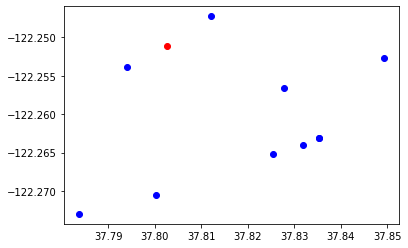

In [50]:
# plotting the user location (red) and the recommended restaurants (blue)
user_lat, user_lng = user['latitude'], user['longitude']
plt.ticklabel_format(useOffset=False)
plt.scatter([user_lat], [user_lng], c='red')
plt.scatter(recommendations.latitude, recommendations.longitude, c='blue')

### On a new user:

In [63]:
user_price = 1
user_lat, user_lng = 39.154215, -123.254658
user_categories = ['pizzarestaurant', 'italianrestaurant', 'fastfoodrestaurant']

recommendations = recommend_to_new_user(df_resto, user_lat, user_lng, user_price, user_categories, model_word2vec, all_categories)
recommendations


User info :
preferred price: 1
location: (39.154215, -123.254658)
preferred categories: ['pizzarestaurant', 'italianrestaurant', 'fastfoodrestaurant']


,name,address,gmap_id,description,latitude,longitude,category,price,hours,MISC,...,norm_lat,us_state,avg_rating,num_of_reviews,norm_lng,resto_code,distance,popularity_score,knowledge_score,score
70230,Isi's Pizza,"Isi's Pizza, 1214 Airport Park Blvd, Ukiah, CA...",0x80816445c7e9a5b7:0xb16dd50a7ca3ef1d,NaN,39.131906,-123.199050,"[pizzarestaurant, deliveryservice, italianrest...",1,"[['Tuesday', '11AM–9PM'], ['Wednesday', '11AM–...","{'Service options': ['No-contact delivery', 'D...",...,0.699223,California,4.289855,138,0.105951,1120,0.059916,4.261423,4.723924,4.631424
11862,Papa Murphy's | Take 'N' Bake Pizza,"Papa Murphy's | Take 'N' Bake Pizza, 1198 N St...",0x808164d8d9718d3d:0x6ded04c58335afd5,Chain outlet offering build-your-own takeaway ...,39.166015,-123.211148,"[pizzarestaurant, familyrestaurant, italianres...",1,"[['Saturday', '11AM–8PM'], ['Sunday', '11AM–8P...","{'Service options': ['Curbside pickup', 'Deliv...",...,0.702842,California,4.102041,98,0.104749,1142,0.045082,4.129376,4.550912,4.466605
25235,Domino's Pizza,"Domino's Pizza, 728 S State St Ste F, Ukiah, C...",0x808165945afe0d69:0xfb42c2ade7255bee,NaN,39.141829,-123.206783,"[pizzadelivery, deliveryrestaurant, takeoutres...",1,"[['Tuesday', '10:30AM–12AM'], ['Wednesday', '1...","{'Service options': ['Curbside pickup', 'No-co...",...,0.700276,California,3.109589,73,0.105182,1186,0.049451,3.545915,4.690506,4.461588
70207,Little Caesars Pizza,"Little Caesars Pizza, 180 Ford Rd, Ukiah, CA 9...",0x808164dbebc355cd:0x6e872553a80e1b6d,"Carry-out chain featuring chicken wings, signa...",39.167915,-123.209050,"[pizzarestaurant, americanrestaurant, chickenw...",1,"[['Tuesday', '10:30AM–9PM'], ['Wednesday', '10...","{'Service options': ['Delivery', 'Takeout', 'D...",...,0.703044,California,3.803738,214,0.104957,1145,0.047621,3.875559,4.600645,4.455628
70221,KFC,"KFC, 1139 N State St, Ukiah, CA 95482",0x808164dec92e59b7:0xd528aa54a65f74d6,Fast-food chain known for its buckets of fried...,39.165330,-123.210272,"[chickenrestaurant, fastfoodrestaurant]",1,"[['Tuesday', '10:30AM–9PM'], ['Wednesday', '10...","{'Service options': ['Curbside pickup', 'Deliv...",...,0.702770,California,3.766055,436,0.104836,1146,0.045757,3.808946,4.587504,4.431793
17994,Dunkin' Donuts,"Dunkin' Donuts, 650 Ford Rd, Ukiah, CA 95482",0x808165cc604605b9:0x2b97cd265c896cf8,NaN,39.167402,-123.197672,[fastfoodrestaurant],1,"[['Sunday', '8AM–7PM'], ['Monday', '7AM–7PM'],...",{'Amenities': ['Good for kids']},...,0.702990,California,1.000000,3,0.106088,1188,0.058492,4.002785,4.512201,4.410318
43413,Pizza Etc,"Pizza Etc, 6951 East Rd B, Redwood Valley, CA ...",0x80817bc40891de69:0x6900249c43cbdfb7,NaN,39.245317,-123.197035,[pizzarestaurant],2,"[['Friday', '3–8PM'], ['Saturday', '3–8PM'], [...","{'Service options': ['Takeout', 'Delivery', 'D...",...,0.711258,California,4.691176,68,0.106151,1204,0.107796,4.475827,4.391924,4.408705
75412,Spiro's Gyros & Deli,"Spiro's Gyros & Deli, 844 S State St, Ukiah, C...",0x80816456c589ae2d:0xa134d55982dfaf94,NaN,39.139614,-123.206278,"[greekrestaurant, deli, fastfoodrestaurant, gy...",1,"[['Friday', '11AM–6PM'], ['Saturday', '11AM–6P...","{'Service options': ['Takeout', 'Delivery', 'D...",...,0.700041,California,4.803030,198,0.105233,1132,0.050535,4.678014,4.310806,4.384248
70224,Chipotle Mexican Grill,"Chipotle Mexican Grill, 596 E Perkins St, Ukia...",0x808164f12340638d:0xb6e3ddabb83c8628,"Fast-food chain offering Mexican fare, includi...",39.151645,-123.199360,"[mexicanrestaurant, caterer, fastfoodrestaurant]",1,"[['Tuesday', '10:45AM–10PM'], ['Wednesday', '1...","{'Service options': ['Outdoor seating', 'Deliv...",...,0.701318,California,4.137168,226,0.105920,1154,0.055358,4.145462,4.386339,4.338164
75830,Carl's Jr.,"Carl's Jr., 1275 N State St, Ukiah, CA 95482",0x808164d855588c57:0x85d6d6bc9666cd3c,Fast-food chain known for its variety of piled...,39.167561,-123.210850,"[fastfoodrestaurant, hamburgerrestaurant]",1,"[['Friday', '6AM–12AM'], ['Saturday', '6AM–12A...","{

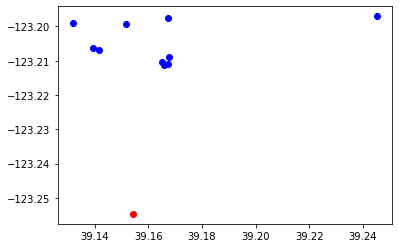

In [64]:
# plotting the user location (red) and the recommended restaurants (blue)
plt.ticklabel_format(useOffset=False)
plt.scatter([user_lat], [user_lng], c='red')
plt.scatter(recommendations.latitude, recommendations.longitude, c='blue')